# Speech Transcription with Whisper
---

Whisper is an open source general purpose speech recognition model produced by OpenAI. It is capable of completing many different tasks such as audio transcription and audio classification. In this notebook, the whisper model is used to perform audio transcription on the LJ Speech dataset available on [Kaggle](https://www.kaggle.com/datasets/mathurinache/the-lj-speech-dataset). 

---

Notes on the package installation:

* The whisper model requires ffmpeg install to run. 
* Huggingface datasets needs to be updated in order to use convert the `Dataset` into an `IterableDataset`.

In [1]:
# pip install whisper model
!pip install -U openai-whisper --quiet

# instal ffmpeg
!sudo apt update && sudo apt install ffmpeg

# install torcheval
!pip install torcheval --quiet

# upgrade datasets
!pip uninstall datasets -y --quiet
!pip install datasets==2.18 --quiet

Get:1 https://packages.cloud.google.com/apt gcsfuse-focal InRelease [1225 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease [1581 B]
Get:3 https://packages.cloud.google.com/apt cloud-sdk InRelease [6361 B]
Get:4 https://packages.cloud.google.com/apt google-fast-socket InRelease [5015 B]
Hit:5 http://archive.ubuntu.com/ubuntu focal InRelease
Get:6 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:7 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  Packages [1500 kB]
Get:9 https://packages.cloud.google.com/apt cloud-sdk/main amd64 Packages [627 kB]
Hit:10 http://archive.ubuntu.com/ubuntu focal-backports InRelease
Get:11 http://security.ubuntu.com/ubuntu focal-security/multiverse amd64 Packages [29.8 kB]
Get:12 http://archive.ubuntu.com/ubuntu focal-updates/restricted amd64 Packages [3639 kB]
Get:13 http://security.ubuntu.com/

In [ ]:
# import python standard library
import warnings
import os
from pathlib import Path
from IPython.display import HTML, display_html, clear_output, Audio

# remove warnings
warnings.filterwarnings('ignore', 'Unable to register * factory' , Warning) 

# import python libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import sklearn.model_selection
import torch
import torcheval.metrics

# import openai version of whisper
import whisper
from whisper.normalizers import EnglishTextNormalizer
from whisper.decoding import decode, DecodingOptions

# import hugging face version of whisper
from transformers import WhisperFeatureExtractor, WhisperTokenizer, WhisperForConditionalGeneration, Seq2SeqTrainingArguments, Seq2SeqTrainer
from datasets import IterableDatasetDict, Dataset

# define directories
input_directory = Path('/kaggle/input/the-lj-speech-dataset/LJSpeech-1.1')
output_directory = Path('/kaggle/working')

# define random state
seed = 42

# define device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
os.environ["CUDA_VISIBLE_DEVICES"]="0"

The metadata uses the vertical line character (`|`) as a separator in the csv. There also appears to be an issue with using the default method available in the Pandas library to load the metadata csv. As such, the csv is read and parsed manually. 

The first thing to note is that the file name does not come with the file type which is `.wav`. More importantly, is the 2 audio transcriptions provided by the metadata. The difference between the 2 appears to be whether numbers are spelled out explicitly or numeric characters are utilized. 

In [3]:
# read metadata file
with open(input_directory / 'metadata.csv') as f:
    lines = f.read().split('\n')
    
# convert into dataframe
metadata = pd.DataFrame(lines, columns=['raw'])

# remove last line as it is empty
metadata = metadata[metadata['raw'].apply(len) > 0].reset_index(drop=True).copy()

# split columns 
metadata[['file_name', 'text']] = metadata['raw'].str.split('|', n=1, expand=True)

# drop raw column
metadata.drop(['raw'], axis=1, inplace=True)

# verify that each text has only 2 given methods of transcription
metadata['text'].str.count('\|').apply(lambda x: x == 1).all()

# split into 2 alternative transcriptions
metadata[['text', 'alt_text']] = metadata['text'].str.split('|', n=1, expand=True)

# remove redundant alt texts
metadata.loc[metadata['text'] == metadata['alt_text'], 'alt_text'] = ''

# show metadata
metadata.head()

,file_name,text,alt_text
0,LJ001-0001,"Printing, in the only sense with which we are ...",
1,LJ001-0002,in being comparatively modern.,
2,LJ001-0003,For although the Chinese took impressions from...,
3,LJ001-0004,"produced the block books, which were the immed...",
4,LJ001-0005,the invention of movable metal letters in the ...,


# Trying out Original Whisper Model from OpenAI
---

The whisper model from OpenAI comes with all the bells and whistles already included. As such, no manual feature extraction is needed to utilize the models. However, the whisper model has 2 additional processors, the feature extractor and the tokenizer.

Based on the results, it seems clear that the model has trouble with punctuation. However, the word error rate is highly inflated as text normalization was not used to remove the punctuation and standardize to lower case. 

In [4]:
# load feature extractor
feature_extractor = WhisperFeatureExtractor.from_pretrained("openai/whisper-base", task='transcribe')

# load tokenizer
tokenizer = WhisperTokenizer.from_pretrained("openai/whisper-base", task="transcribe")

def get_whisper_model(model_type: str = 'base', device='cpu') -> torch.nn.Module:
    model = whisper.load_model(model_type, device)
    return model

def display_results(file_name: str, text: str, alt_text: str, prediction: str) -> None:
    print(f"File           : {file_name}")
    print(f"Actual         : {text}")
    if alt_text != '':
        print(f"Alternative    : {alt_text}")
    print(f"Prediction     : {prediction}")
    print(f"Word Error Rate: {min(torcheval.metrics.functional.word_error_rate(text, prediction), torcheval.metrics.functional.word_error_rate(alt_text, prediction)) * 100}")
    print()

preprocessor_config.json:   0%|          | 0.00/185k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/283k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/836k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.48M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/494k [00:00<?, ?B/s]

normalizer.json:   0%|          | 0.00/52.7k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.19k [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [5]:
# number of files to pick to test whisper model
sample = 5

# pick files
test_records = metadata.sample(n=sample, replace=False, random_state=seed).reset_index(drop=True)

# load model
model = get_whisper_model('base')

# get transcriptions
output = []
with warnings.catch_warnings(): 
    warnings.filterwarnings('ignore', 'FP16 is not supported on CPU; using FP32 instead' , Warning) # remove warnings if running on cpu
    for file in test_records['file_name'].to_list():
        result = model.transcribe(str(input_directory / 'wavs' / (file + '.wav')))
        text = result['text'].strip()
        output.append(text)
test_records['prediction'] = pd.Series(output)

# display results
for i, row in test_records.iterrows():
    row = row.to_dict()
    
    display_results(**row)

100%|████████████████████████████████████████| 139M/139M [00:01<00:00, 137MiB/s]
/opt/conda/lib/python3.10/site-packages/whisper/transcribe.py:113: UserWarning: Performing inference on CPU when CUDA is available
  warnings.warn("Performing inference on CPU when CUDA is available")
/opt/conda/lib/python3.10/site-packages/whisper/transcribe.py:113: UserWarning: Performing inference on CPU when CUDA is available
  warnings.warn("Performing inference on CPU when CUDA is available")
/opt/conda/lib/python3.10/site-packages/whisper/transcribe.py:113: UserWarning: Performing inference on CPU when CUDA is available
  warnings.warn("Performing inference on CPU when CUDA is available")
/opt/conda/lib/python3.10/site-packages/whisper/transcribe.py:113: UserWarning: Performing inference on CPU when CUDA is available
  warnings.warn("Performing inference on CPU when CUDA is available")
/opt/conda/lib/python3.10/site-packages/whisper/transcribe.py:113: UserWarning: Performing inference on CPU when CU

File           : LJ015-0247
Actual         : At that station the safes were given out, heavy with shot, not gold; the thieves went on to Dover, and by-and-by,
Prediction     : At that station, the shapes were given out, heavy with shot, not gold. The thieves went on to dover, and by and by.
Word Error Rate: 34.78260869565217

File           : LJ028-0475
Actual         : No traces of its moat have appeared.
Prediction     : No traces of its moat have appeared.
Word Error Rate: 0.0

File           : LJ013-0049
Actual         : A notorious miser, Robert Smith, had recently died in Seven Dials, where he had amassed a considerable fortune.
Prediction     : A notorious miser, Robert Smith, had recently died in seven dials where he had amassed a considerable fortune.
Word Error Rate: 11.11111111111111

File           : LJ005-0119
Actual         : No attempt was made to maintain discipline.
Prediction     : No attempt was made to maintain discipline.
Word Error Rate: 0.0

File           : LJ00

In [6]:
def play_audio(file_name: str) -> Audio:
    path = str(input_directory / f'wavs/{file_name}.wav')
    return Audio(path)

# display samples from train dataset
row = test_records.sample().iloc[0].to_dict()
print("Text:", row['text'])
play_audio(row['file_name'])

Text: No traces of its moat have appeared.


# Visualizing Effect of Feature Extractor
---

The LJ dataset audio files are single channel 16-bit  WAV with a sample rate of 22050 Hz. However, whisper was trained using audio with a sampling rate of 16000 Hz. Thankfully, a function is provided to load the audio files and it performs the resampling automatically. The alternative would be to use `torchaudio` or `librosa` to resample the audio.

The feature extractor converts an audio file (a 1D array) into a log mel spectrogram (a 2D image). Since the audio files are all shorter than 30s, it also pads the spectrogram to the correct size. 

In [7]:
# original sampling rate was 22050Hz
# however whisper was trained at 16000Hz
sampling_rate = 16000 

def read_audio(file_name: str) -> np.ndarray:
    audio = whisper.load_audio(str(input_directory / f'wavs/{file_name}.wav'), sr=sampling_rate)
    return audio

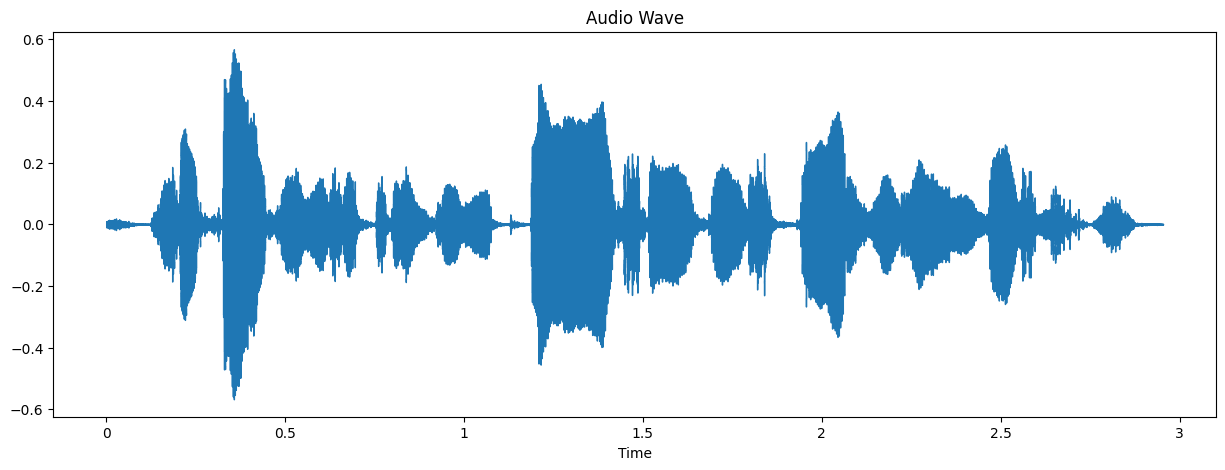

In [8]:
# display samples from train dataset
row = metadata.sample().iloc[0].to_dict()

# load audio file
audio = read_audio(row['file_name'])

# display audio wave
plt.figure(figsize=(15,5))
librosa.display.waveshow(audio)
plt.title("Audio Wave")
plt.show()

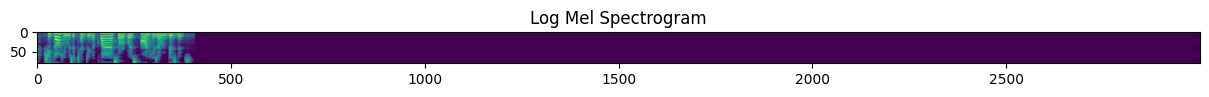

In [9]:
# preprocess
spectrogram = feature_extractor(audio, sampling_rate=sampling_rate)['input_features'][0]

# display log mel spectrogram
plt.figure(figsize=(15,5))
plt.title("Log Mel Spectrogram")
plt.imshow(spectrogram)
plt.show()

# Visualizing Effect of Tokenizer
---

The tokenizer provides a reversible mapping between words and indexes as shown below.

In [10]:
# simple test case to verify tokenizer works as intended
# display samples from train dataset
row = metadata.sample().iloc[0].to_dict()

# test forward and backward tokenization
encoded = row['text']
tokens = tokenizer(encoded)['input_ids']
decoded = tokenizer.decode(tokens, skip_special_tokens=True)

# display results
assert encoded == decoded, "Tokenizer made a mistake"
print(f"Initial: {encoded}")
print(f"Tokens : {tokens}")
print(f"Output : {decoded}")

Initial: he whispered in the ear of the German pastor who attended him on the scaffold,
Tokens : [50258, 50359, 50363, 675, 26018, 292, 294, 264, 1273, 295, 264, 6521, 21193, 567, 15990, 796, 322, 264, 44094, 11, 50257]
Output : he whispered in the ear of the German pastor who attended him on the scaffold,


# Fine Tuning Using HuggingFace
---

HuggingFace provides methods to quickly and conveniently fine-tune the whisper model. The library abstracts a lot of the details and makes it easy to use but hard to understand whats going on under the hood.

After 100 steps, the model actually improved by a decent amount. However, 100 steps only means that the model trained for 400 records only, a fraction of the total number of training records. A proper fine-tuning session would definitely take a significantly longer time then available on kaggle to complete.

In [11]:
# create train and test set
train_df, test_df = sklearn.model_selection.train_test_split(metadata, test_size=0.2, random_state=seed)
train_df, valid_df = sklearn.model_selection.train_test_split(train_df, test_size=0.25, random_state=seed)

train_df.to_csv('train_df.csv', index=False)
valid_df.to_csv('valid_df.csv', index=False)
test_df.to_csv('test_df.csv', index=False)

print(f"Number of train records     : {len(train_df)}")
print(f"Number of validation records: {len(valid_df)}")
print(f"Number of test records      : {len(test_df)}")

Number of train records     : 7860
Number of validation records: 2620
Number of test records      : 2620


In [12]:
# create datasets
dataset = IterableDatasetDict()

def load_audio(args: pd.Series) -> dict:
    file_name = args['file_name']
    text = args['text']
    output = {}

    # load audio in the same fashion as intented
    # resample to desired sampling rate
    output = {}
    output['path'] = str(input_directory / 'wavs' / f'{file_name}.wav')
    output['sampling_rate'] = 16000
    output['array'] = whisper.load_audio(output['path'], sr=output['sampling_rate'])
    
    return output

def load_dataset(df : pd.DataFrame) -> Dataset:
    df['audio'] = df.apply(load_audio, axis=1)
    return Dataset.from_pandas(df, preserve_index = False)

dataset['train'] = load_dataset(train_df).to_iterable_dataset()
dataset['validation'] = load_dataset(valid_df).to_iterable_dataset()
dataset['test'] = load_dataset(test_df).to_iterable_dataset()

dataset = dataset

In [13]:
# apply preprocessors
def preprocess_dataset(record: dict) -> dict:
    # preprocess audio
    audio = record['audio']
    with warnings.catch_warnings(): 
        warnings.filterwarnings('ignore', 'Unable to register * factory' , Warning) 
        record['input_features'] = feature_extractor(audio['array'], sampling_rate=audio['sampling_rate'], return_tensors='pt')['input_features'].squeeze()
    
    # preprocess text
    record['labels'] = tokenizer(record['text'])['input_ids']
    
    return record

dataset = dataset.map(preprocess_dataset)

In [14]:
# define collation function to turn list of individual records into a batch to pass through the model
def collation_fn(records: list[dict[str, torch.tensor]]) -> dict[str, torch.tensor]:
    output = feature_extractor.pad([{"input_features": record['input_features']} for record in records], return_tensors='pt')
    output['labels'] = tokenizer.pad([{"input_ids": record['labels']} for record in records], return_tensors='pt')
    output['labels'] = torch.where(output['labels']['attention_mask'] == 1, output['labels']['input_ids'], 50256) # 50256 is the token for padding
    return output

In [15]:
normalizer = EnglishTextNormalizer()

# define word error rate
def compute_metrics(prediction: dict) -> dict:
    # extract ids
    preds = prediction.predictions
    actual = prediction.label_ids
    
    # convert to strs
    preds = tokenizer.batch_decode(preds, skip_special_tokens=True, normalize=True)
    actual = tokenizer.batch_decode(actual, skip_special_tokens=True, normalize=True)
    
    # calculate wer
    wer = torcheval.metrics.functional.word_error_rate(preds, actual) * 100
    
    return {'wer': wer}

In [16]:
model = WhisperForConditionalGeneration.from_pretrained('openai/whisper-base')
model.generation_config.language = "en"
model.generation_config.task = "transcribe"
model.generation_config.forced_decoder_ids = None
model.generation_config.use_cache = False
model.generation_config.max_length = 448
model.generation_config.suppress_tokens = [1, 2, 7, 8, 9, 10, 14, 25, 26, 27, 28, 29, 31, 58, 59, 60, 61, 62, 63, 90, 91, 92, 93, 359, 503, 522, 542, 873, 893, 902, 918, 922, 931, 1350, 1853, 1982, 2460, 2627, 3246, 3253, 3268, 3536, 3846, 3961, 4183, 4667, 6585, 6647, 7273, 9061, 9383, 10428, 10929, 11938, 12033, 12331, 12562, 13793, 14157, 14635, 15265, 15618, 16553, 16604, 18362, 18956, 20075, 21675, 22520, 26130, 26161, 26435, 28279, 29464, 31650, 32302, 32470, 36865, 42863, 47425, 49870, 50254, 50258, 50358, 50359, 50360, 50361, 50362]
model.generation_config.begin_suppress_tokens = [220, 50257]

del model.config.max_length
del model.config.suppress_tokens
del model.config.begin_suppress_tokens

config.json:   0%|          | 0.00/1.98k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/290M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/3.81k [00:00<?, ?B/s]

In [17]:
training_args = Seq2SeqTrainingArguments(
    output_dir="./whisper",  
    per_device_train_batch_size=4,
    gradient_accumulation_steps=4,  
    learning_rate=1e-5,
    warmup_steps=10,
    max_steps=100,
    gradient_checkpointing=True,
    fp16=False,
    evaluation_strategy="steps",
    per_device_eval_batch_size=4,
    predict_with_generate=True,
    generation_max_length=225,
    save_steps=20,
    eval_steps=20,
    logging_steps=20,
    report_to=['tensorboard'],
    load_best_model_at_end=True,
    metric_for_best_model="wer",
    greater_is_better=False,
    push_to_hub=False,
)

In [18]:
trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    data_collator=collation_fn,
    compute_metrics=compute_metrics,
    tokenizer=feature_extractor,
)

/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [19]:
with warnings.catch_warnings(): 
    warnings.filterwarnings('ignore', 'torch.utils.checkpoint' , Warning) 
    trainer.train()

`use_cache = True` is incompatible with gradient checkpointing. Setting `use_cache = False`...


Step,Training Loss,Validation Loss,Wer
20,3.309000,1.611563,3.696322
40,1.269100,0.998490,3.680467
60,0.779900,0.714597,3.569487
80,0.627500,0.563904,3.515130
100,0.515400,0.516966,3.512865


There were missing keys in the checkpoint model loaded: ['proj_out.weight'].


In [20]:
# evaluation
wer_fn = torcheval.metrics.WordErrorRate()
with torch.inference_mode():
    for record in dataset['test']:
        input_record = record['input_features'].unsqueeze(axis=0).to(device)
        predictions = model.generate(input_record)[0]
        predictions = tokenizer.decode(predictions, skip_special_tokens=True, normalize=True)
        actual = tokenizer.decode(record['labels'], skip_special_tokens=True, normalize=True)
        wer_fn.update([predictions], [actual])
    wer = wer_fn.compute().item() * 100
print(f"Word Error Rate: {wer}")

Word Error Rate: 3.0285511165857315


In [21]:
model = model.cpu()
del model
torch.cuda.empty_cache()

# Fine Tuning using PyTorch
---

In order to understand how the seq2seq trainer functions, I attempted to mimic the fine-tuning using pytorch alone. The whisper model is a instance of `torch.nn.Module` and can be treated like any other pytorch model. The exception is how the training process works. The loss function is the categorical cross entropy which is easily computed from the logits outputed by the model. However, it is not possible to generate the words from the predicted logits. So, it is a time consuming process to calculate the word error rate metric as the `generate` method needs to be utilized. 

An attempt was made to recreate the training parameters used by OpenAI when training the model. However, the initial learning rate was clearly too high and was adjusted to `1e-5` instead. And due to the limited memory available on the gpu, small batches and gradient accumulation was used to train the model. 

The performance of the model barely changed. However, that is to be expected consider that the model only saw 80 records. The important thing is that the flow of data through the model and training loop was successful considering that it is not realistic to properly fine-tune the model on Kaggle.

In [22]:
def preprocess(file_name: str) -> torch.tensor:
    audio = read_audio(file_name)
    spectrogram = feature_extractor(audio, sampling_rate=sampling_rate, return_tensors = 'pt')['input_features'][0]
    return spectrogram

def tokenize(text: list[str]) -> torch.tensor:
    tokens = tokenizer(text)['input_ids']
    encoded = tokenizer.pad([{'input_ids': token} for token in tokens], return_tensors="pt", padding=True)
    input_ids = encoded['input_ids']
    mask = encoded['attention_mask']
    input_ids = torch.where(mask == 1, input_ids, 50256)
    return input_ids

def collation_function(samples: list[dict]) -> tuple[torch.tensor]:
    inputs = torch.stack([preprocess(x['file_name']) for x in samples])
    labels = tokenize([x['text'] for x in samples])
    return inputs, labels

class CustomDataSet(torch.utils.data.IterableDataset):
    def __init__(self, data: pd.DataFrame, shuffle: bool = False):
        super().__init__()
        self.data = data
        
    def __iter__(self):
        data = self.data.sample(len(self.data))
        def create_generator():
            for i, row in data.iterrows():
                yield row.to_dict()
        return create_generator()

# create data sets
train_ds = CustomDataSet(train_df, shuffle=True)
valid_ds = CustomDataSet(valid_df)
test_ds = CustomDataSet(test_df)

# create data loaders
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=4, collate_fn=collation_function)
valid_dl = torch.utils.data.DataLoader(valid_ds, batch_size=4, collate_fn=collation_function)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=4, collate_fn=collation_function)

In [23]:
# load model
model = get_whisper_model().to(device)

# number of steps
updates = 20

# optimizer parameters are taken from openai's whisper paper
warmup_updates = 4
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5 ,betas=(0.9, 0.98), eps=1e-6, weight_decay=0.1)
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, total_iters=warmup_updates)

grad_norm = lambda parameters: torch.nn.utils.clip_grad_norm_(parameters, max_norm=1.0)

# No speechless audio -> difference from original training

loss_fn = torch.nn.CrossEntropyLoss()

logging_steps = 4
grad_accumulate = 4

decoding_options = DecodingOptions(fp16=False)

In [24]:
def display_progress(progress: dict[str, float]) -> None:
    clear_output()
    headers = '' 
    if len(progress.keys()) != 0:
        headers = '<tr><td><b>' + '</b></td><td><b>'.join([str(k) for k in progress.keys()]) + '</b></td></tr>'
    rows = []
    if len(progress.values()) != 0:
        for i in range(len(list(progress.values())[0])):
            rows.append('<tr><td>' + '</td><td>'.join([str(progress[k][i]) for k in progress.keys()]) + '</td></tr>')
    html = HTML("<table>" + headers + '\n'.join(rows) + '</table>')
    display_html(html)

In [25]:
generators = {
    'train': iter(train_dl),
    'valid': iter(valid_dl)
}
progress = {
    "Step": [],
    "Training loss": [],
    'Validation loss': [],
    'Word Error Rate': []
}

# zero gradients for accumulation
optimizer.zero_grad()
for i in range(updates):
    # get training data
    try: 
        X, y = next(generators['train'])
    except StopIteration: 
        generators['train'] = iter(train_dl)
        X, y = next(generators['train'])
    
    # move to correct device
    X = X.to(device)
    y = y.to(device)
    
    # set to training mode
    model.train()
    
    # calculate loss and gradients
    predictions = model(X, y)
    y_ = torch.nn.functional.one_hot(y, predictions.shape[-1]).type(torch.float32)
    training_loss = loss_fn(predictions, y_)
    training_loss.backward()
    
    # last step for gradient accumulation
    if i % grad_accumulate == grad_accumulate - 1:
        # apply gradient clipping
        grad_norm(model.parameters())
        
        # update weights
        optimizer.step()
        scheduler.step()
        
        # re-zero gradients
        optimizer.zero_grad()
    
    if i % logging_steps == logging_steps - 1:
        # append training details
        progress['Step'].append(i)
        progress['Training loss'].append(training_loss.detach().item())
        
        # evaluate
        model.eval()
        with torch.inference_mode():
            b = len(valid_df) # total size of test dataset
            validation_loss = 0
            wer_fn = torcheval.metrics.WordErrorRate()
            
            # loop throught the test data
            for X, y in valid_dl:
                # move to correct device
                X = X.to(device)
                y = y.to(device)
                
                # make predictions
                predictions = model(X, y)
                
                # calculate loss
                y_ = torch.nn.functional.one_hot(y, predictions.shape[-1]).type(torch.float32)
                i = X.shape[0]
                validation_loss += loss_fn(predictions, y_).item() * i / b
            
                # calculate metrics
                results = decode(model, X, decoding_options)
                predicted_tokens = [r.tokens for r in results]
                predicted = tokenizer.batch_decode(predicted_tokens, normalize=True, skip_special_tokens=True)
                actual = tokenizer.batch_decode(y, normalize=True, skip_special_tokens=True)
                wer_fn.update(predicted, actual)
                
            # append validation details
            progress['Validation loss'].append(validation_loss)
            wer = wer_fn.compute().item() * 100
            progress['Word Error Rate'].append(wer)
        display_progress(progress)

Step,Training loss,Validation loss,Word Error Rate
3,0.011049260385334492,0.008462262658743567,3.798242285847664
7,0.01086642686277628,0.006268080007924724,3.77332866191864
11,0.004941902123391628,0.004590800738331815,3.7620041519403458
15,0.005207719746977091,0.003370090076017354,3.7687987089157104
19,0.002805484225973487,0.0024000972825749486,3.7280306220054626


In [26]:
model.eval()
loss = 0
wer_fn = torcheval.metrics.WordErrorRate()
b = len(test_df) # total size of test dataset
with torch.inference_mode():
    for X, y in test_dl:
        X = X.to(device)
        y = y.to(device)
        i = X.shape[0]
        
        predictions = model(X, y)
        y_ = torch.nn.functional.one_hot(y, predictions.shape[-1]).type(torch.float32)
        loss += loss_fn(predictions, y_).item() * i/b
        
        results = decode(model, X, decoding_options)
        predicted_tokens = [r.tokens for r in results]
        predicted = tokenizer.batch_decode(predicted_tokens, normalize=True, skip_special_tokens=True)
        actual = tokenizer.batch_decode(y, normalize=True, skip_special_tokens=True)
        wer_fn.update(predicted, actual)
    wer = wer_fn.compute().item() * 100
print(f"Testing loss: {loss}")
print(f"Word Error Rate: {wer}")

Testing loss: 0.002410852707716286
Word Error Rate: 3.782353550195694
